<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/TextCNN_with_USE_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Important Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import tensorflow_hub as hub
from bs4 import BeautifulSoup

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Loading and Reading the dataset

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#Posts Preprocessing

In [ ]:
# Applying heuristic techinques to reduce noice in the data
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)

# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())

### Save the cleaned dataset

In [ ]:
# Save the cleaned dataset as an Excel file
dataset.to_excel('cleaned_14932_ARPs_and_Programming_Posts.xlsx', index=False, engine='openpyxl')

In [ ]:
# Text lemmatizer, stopwords removal, etc
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)

In [ ]:
# Save processed dataset
#dataset.to_excel('NameOftheFile.xlsx', index=False)

#dataset.head()

In [ ]:
# Preprocess the data
X = dataset['Question_body_preprocessed']
y = dataset['Label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Load the USE Model

In [ ]:
# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Split the data into training and testing sets

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train_use = embed(X_train.to_list()).numpy()
X_test_use = embed(X_test.to_list()).numpy()

In [ ]:
X_train_use = np.expand_dims(X_train_use, axis=-1)
X_test_use = np.expand_dims(X_test_use, axis=-1)

# Defining TextCNN model

In [ ]:
def create_text_cnn_model_use(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = Conv1D(128, 3, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(inputs)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(inputs)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Create the model

In [ ]:
# Create the model
input_shape = (X_train_use.shape[1], X_train_use.shape[2])
text_cnn_model_use = create_text_cnn_model_use(input_shape)

## Display the model summary

In [ ]:
# Display the model summary
text_cnn_model_use.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 510, 128)       │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 509, 128)       │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 508, 128)       │            768 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 255, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 254, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 254, 128)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 763, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 97664)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     12,501,120 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,503,169 (47.70 MB)

 Trainable params: 12,503,169 (47.70 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = text_cnn_model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_data=(X_test_use, y_test), callbacks=[early_stopping])

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 133s 357ms/step - accuracy: 0.9481 - loss: 0.1383 - val_accuracy: 0.9237 - val_loss: 0.2033
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 141s 377ms/step - accuracy: 0.9548 - loss: 0.1247 - val_accuracy: 0.9203 - val_loss: 0.2177
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 132s 349ms/step - accuracy: 0.9610 - loss: 0.1125 - val_accuracy: 0.9213 - val_loss: 0.2218
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 146s 360ms/step - accuracy: 0.9681 - loss: 0.0926 - val_accuracy: 0.9247 - val_loss: 0.2396
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 142s 359ms/step - accuracy: 0.9739 - loss: 0.0768 - val_accuracy: 0.9186 - val_loss: 0.2675
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.9782 - loss: 0.0642 - val_accuracy: 0.9193 - val_loss: 0.2815
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 152s 383ms/step - accuracy: 0.9796 - loss: 0.0604 - val_accuracy: 0.9213 - val_loss: 0.2967
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 193s 359ms/step - accuracy: 0.9848 -

## Evaluate the model

In [ ]:
# Evaluate the model
loss, accuracy = text_cnn_model_use.evaluate(X_test_use, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Predict on new data
y_pred = text_cnn_model_use.predict(X_test_use)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true_classes = y_test

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9236 - loss: 0.3590
Test Accuracy: 0.9197
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


## Evaluate the model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Predict on new data
y_pred = text_cnn_model_use.predict(X_test_use)

# Convert predictions to class labels (binary classification)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true_classes = y_test

conf_matrix = confusion_matrix(y_test, y_pred_classes)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average='binary')
overall_accuracy = accuracy_score(y_test, y_pred_classes)

# Print overall metrics for both classes
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
Overall Precision: 0.9240162822252375
Overall Recall: 0.9140939597315436
Overall F1-score: 0.9190283400809717
Overall Accuracy: 0.9196518245731503


## Prediction results analysis with Confusion Matrix

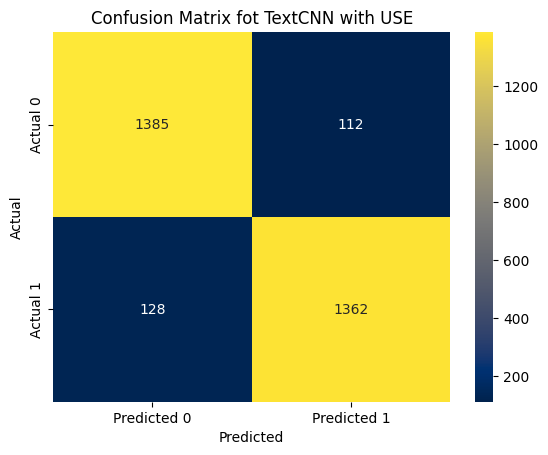

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with USE')
plt.show()
